<a href="https://colab.research.google.com/github/byungkim0068/git-and-github-fundamentals-byungkim0068-/blob/main/Kinetics_ModelingData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dr Oliviero Andreussi, olivieroandreuss@boisestate.edu

Boise State University, Department of Chemistry and Biochemistry

# Fitting and Data Analysis for the Kinetics of Methylene Blue RedOx Experiment {-}

Before we start, let us import the main modules that we will need for this lecture. You may see some new modules in the list below, we will add more details in the right sections.

In [1]:
# Import the main modules used in this worksheet
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
import scipy.optimize

We need to load the Google Drive and access an example of a dataset from a kinetics experiment. You can use the same set that I am using by downloading it from Canvas, [here](https://boisestatecanvas.instructure.com/courses/20544/files/10204032?wrap=1). Or you can use your own files. I am assuming the file in question will be located in a `Kinetics_Data/` subfolder in your `Colab Notebook/` folder. I will be using a file named `SetArun1.csv`, make sure to change this name if you use a different file.

In [6]:
# Load the google drive with your files
from google.colab import drive
drive.mount('/content/drive')
# The following needs to be the path of the folder with all your collected data in .csv format
path='/content/drive/MyDrive/PChemLab-main/Kinetics_Data/'
file='SetArun1.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We can read the file into a `Pandas.DataFrame` object using the `pd.read_csv()` function. Note that the file in question has two columns and the label for the columns are in the second row. The first column contains the time of the experiment in seconds, the second column contains the absorbance of the solution recorded by the UV/Vis apparatus. However, at the end of the file there are several lines with information on the experiment. When `Pandas` reads these lines it gets confused on the type of data in the columns and on the number of columns. We could clean up the files before processing them or we can help `Pandas` clean up the data.

In [7]:
# The header=1 option tells Pandas to find the column names in the second line of the file
# The usecols=(0,1) options tells Pandas to only collect the first two columns of data
data=pd.read_csv(path+file,header=1,usecols=(0,1))
# The data read so far contains strings and strange things at the end of the file
# We can clean it by forcing Pandas to convert the strings to numbers
# Actual strings will return an error, which Pandas will save as NaN
# adding the .dropna() function at the end get rids of these cells
data=data.apply(pd.to_numeric,errors='coerce').dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 818 entries, 0 to 817
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Time (sec)  818 non-null    float64
 1   Abs         818 non-null    float64
dtypes: float64(2)
memory usage: 19.2 KB


We can plot the experimental data as usual using `Matplotlib.Pyplot` functions.

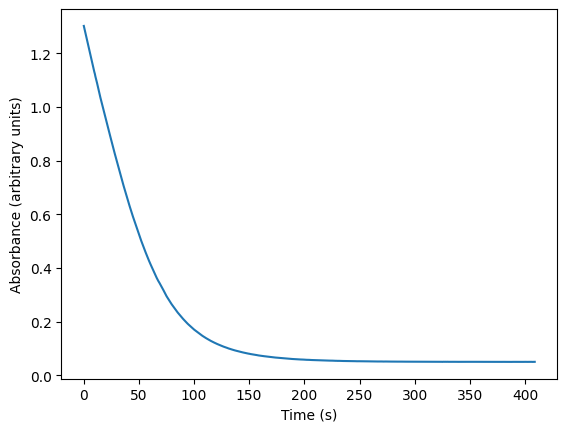

In [8]:
plt.plot(data['Time (sec)'],data['Abs'])
plt.xlabel('Time (s)')
plt.ylabel('Absorbance (arbitrary units)')
plt.show()

We can also plot the same data using a semilog plot (with the y-axis in log scale)

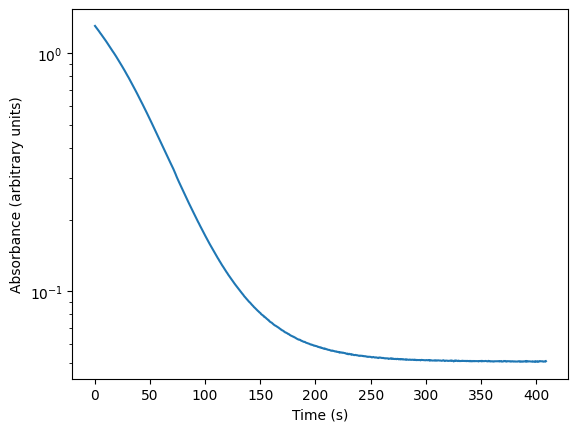

In [9]:
plt.semilogy(data['Time (sec)'],data['Abs'])
plt.xlabel('Time (s)')
plt.ylabel('Absorbance (arbitrary units)')
plt.show()

## Trying to Fit with Simple Linear Regression {-}

It would be nice if we could just use the linear regression algorithm that we have used before to fit the kinetics curves. However, one of our tasks requires to identify the order of the reaction with respect to the concentration of methylene blue (abbreviated in $[MB]$ in the following). Different orders of kinetics correspond to different decay curves.
* A reaction that is of zeroth order will have a linear decay in $[MB]$, i.e. $[MB](t)=[MB0]-kt$
* A reaction that is of first order will have an exponential decay in $[MB]$, i.e. $[MB](t)=[MB0]e^{-kt}$
* A reaction that is of second order will have a decay inversile proportional to $[MB]$, i.e. $[MB](t)=\frac{1}{1/[MB0]+kt}$


In principles, if we make the appropriate change of variables, we can linearize all three of the above equations and try to use linear regression to perform the fit of the data.

In [10]:
first_order=LinearRegression()
x=data['Time (sec)'].values.reshape(-1,1)
y=data['Abs'].values
first_order.fit(x,y)
print(first_order.score(x,y),first_order.coef_[0])

0.5018089447048474 -0.0017145742113715385


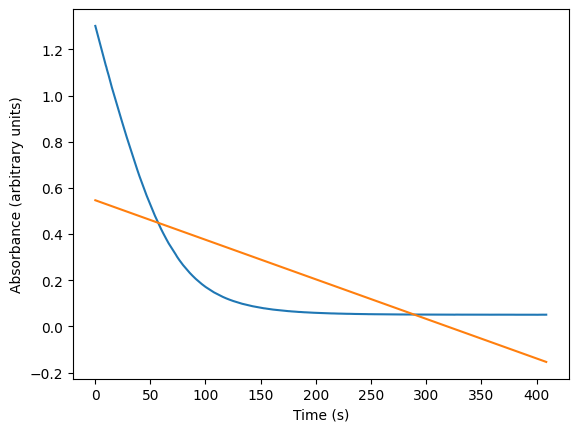

In [11]:
plt.plot(data['Time (sec)'],data['Abs'])
plt.plot(data['Time (sec)'],first_order.predict(x))
plt.xlabel('Time (s)')
plt.ylabel('Absorbance (arbitrary units)')
plt.show()

Can you try to fit the same data using a first order or a second order model? You will need to change the definition of the dependent variable to make the linear fit appropriate. For the first order you want to fit $log([MB])$ while for the second order model you want to fit $1/[MB]$.

In [12]:
# feel free to copy some of the linear regression commands above

Which of the models works the best? Is any of the model giving a decent fit of the data? Why or why not? Is the linearization trick always appropriate?

## Alternative Fit using Scipy {-}

One of the possible causes of poor fitting is the fact that our experimental results do not go to zero exactly, but they converge to a baseline, i.e. there is an offset in the data. Unfortunately the offset is tricky to remove and it makes the linearization trick fail. However, we can still try to fit using a non-linear model. The algorithm that optimize an arbitrary model, even those that are non-linear in the parameters, are a bit more tricky to use. They are not able to get the optimal solution directly, but rather they need to optimize the solution one step at the time. The starting point of the algorithm is usually important to ensure convergence and that we get to the best set of parameters.

Scipy adds many useful features to standard Python. It has a submodule devoted to optimization algorithm, including a `Scipy.Optimize.Curve_Fit()` function that works for non-linear functions. The tricky part of using this function is that we need to pass the functional that we want to optimize to it. Let us assume that we try to optimize a linear function that also has an offset (and cannot become indefinitely low).

In [13]:
def linear(t, a, k, o):
    """
    Function that returns a linear decaying function that saturates to an offset
    f(t) = o + a - k * t (for t < a/k) or o (for t > a/k)

    input variables
    t: input value (units of time)
    a: amplitude (units of absorbance or concentration)
    k: decay rate (units of 1/time)
    o: offset (units of absorbance or concentration)
    """
    filter = t < a/k
    return o + filter * (a - k * t)

In [14]:
p0 = (0.45, 0.002, 0.05) # this are the starting values of the parameters of the function
params, cv = scipy.optimize.curve_fit(linear,data['Time (sec)'],data['Abs'],p0)

The fit returns two objects:
* the first one contains the value of the optimal parameters, those that give the smallest deviation from the experimental curve
* the seonc object contains the covariance matrix of the parameters: the diagonal of this matrix has the variance in the estimate of the parameter, which you can use as an error estimate for your parameter

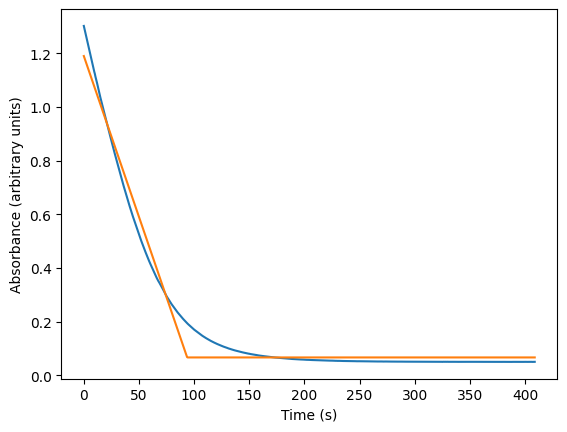

In [15]:
plt.plot(data['Time (sec)'],data['Abs'])
plt.plot(data['Time (sec)'],linear(data['Time (sec)'],params[0],params[1],params[2]))
plt.xlabel('Time (s)')
plt.ylabel('Absorbance (arbitrary units)')
plt.show()

Can you try to define two functions for the first-order and second-order models that also include an offset? Use `curve_fit()` to fit the experiment with these two functions, which model agrees the best with the experiment?